In [2]:
# %%writefile Ind_MoM_Effect.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tools.Sample_Tools as smpl

from base.JuUnits import excute_for_multidates


# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base




In [158]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    df_all = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
else:
    df_all = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

# df_treated = pretreate_data(df_all)

data_ = df_all.loc['2017-01-03':'2020-12-28']

codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()
data_replenish = load_cache_adv('all_train_qfq',
                                dates.min().strftime('%Y-%m-%d'),
                                dates.max().strftime('%Y-%m-%d'),
                                cache_type=CACHE_TYPE.STOCK).sort_index()

ret = smpl.get_forward_return(data_replenish,'close')
ret.name = 'ret_forward'
ret[np.abs(ret)>0.15]=np.nan

In [159]:
#日间反转-波动翻转
# 1）每天计算所有股票的日间收益率。
# 2）每月月底计算最近20天的日间收益率的均值和标准差，作为当月的日间收益率和日间波动率。
# 3）比较每只股票的日间波动率与市场截面均值的大小关系，将日间波动率小于市场均值的股票，
# 视为“硬币”型股票，由于未来其发生动量效应的概率更大，因此我们将其当月日间收益率乘以-1；
# 而日间波动率大于市场均值的股票，视为“球队”型股票，其未来将发生反转效应的概率更大，
# 其因子值保持不变。
# 我们将变换后的因子作为修正后的新反转因子，记为“日间反转-波动翻转”因子

cur_ret = smpl.get_current_return(data_,'close')
turnover = data_['volume'] / (data_['lshares'] *100) # 手/万股

ret_std20 = excute_for_multidates(cur_ret, lambda x:x.rolling(20).std(), level=1)

market_std = excute_for_multidates(ret_std20, lambda x:x.mean(), level=0)
condition = excute_for_multidates(ret_std20, lambda x:x<market_std[x.index.get_level_values(0)[0]], level=0)
interday_fluctuation_reverse = cur_ret*condition.map({True:-1,False:1})
interday_fluctuation_reverse = excute_for_multidates(interday_fluctuation_reverse, lambda x:x.rolling(20).mean(), level=1)

# “日间反转-换手翻转”
# 因子的定义接下来我们使用换手率的变化量这一指标，在日频维度上，寻找可能发生动量效应的股票，并将其这一天的日间涨跌幅翻转过来。
# 1）计算每支股票t日换手率与t-1日换手率的差值，作为t日换手率的变化量。
# 2）将每只股票的换手率变化量与当日全市场的换手率变化量的均值做比较，我们认为换手率变化量高于市场均值的股票为“球队”型股票，其未来将大概率发生反转效应；换手率变化量低于市场均值的，为“硬币”股票，未来将大概率发生动量效应。
# 3）我们计算每只股票t日的日间收益率，将“硬币”型股票的日间收益率乘以-1，而“球队”型股票的日间收益率保持不变。记变化后的日间收益率为“翻转收益率”。
# 4）每月月底，计算最近20天的“翻转收益率”的均值，我们将变换后的因子作为经修正后的新反转因子，记为本月的“日间反转-换手翻转”因子。
turnover_dif = excute_for_multidates(turnover, lambda x:x.diff(), level=1)
market_turnover_dif = excute_for_multidates(turnover_dif, lambda x:x.mean(), level=0)
condition = excute_for_multidates(turnover_dif, lambda x:x<market_turnover_dif[x.index.get_level_values(0)[0]], level=0)
interday_turnover_reverse = cur_ret*condition.map({True:-1,False:1})
interday_turnover_reverse = excute_for_multidates(interday_turnover_reverse, lambda x:x.rolling(20).mean(), level=1)

mixed = interday_fluctuation_reverse*0.5 + interday_turnover_reverse*0.5


# 日内反转-波动翻转
# 1）每天计算每只股票的日内收益率。
# 2）每月月底计算最近20天的日内收益率的均值和标准差，作为当月的日内收益率和日内收益率的波动率。
# 3）比较每只股票的日内收益率的波动率与市场截面均值的大小关系，将日内收益率的波动率小于市场均值的股票，视为“硬币”型股票，其未来发生动量效应的概率更大，
# 因此我们将其当月日内收益率乘以-1；而日内收益率的波动率大于市场均值的股票，视为“球队”型股票，其未来将发生反转效应的概率更大，其当月日内收益率保持不变。
# 我们将变换后的因子作为修正后的新日内反转因子，记为“日内反转-波动翻转”因子
intra_ret = data_['close'] / data_['open'] -1
intra_ret_std20 = excute_for_multidates(intra_ret, lambda x:x.rolling(20).std(), level=1)

intra_market_std = excute_for_multidates(intra_ret_std20, lambda x:x.mean(), level=0)
condition = excute_for_multidates(intra_ret_std20, lambda x:x<intra_market_std[x.index.get_level_values(0)[0]], level=0)
intraday_fluctuation_reverse = intra_ret*condition.map({True:-1,False:1})
intraday_fluctuation_reverse = excute_for_multidates(intraday_fluctuation_reverse, lambda x:x.rolling(20).mean(), level=1)

# 日内反转-换手翻转
condition = excute_for_multidates(turnover_dif, lambda x:x<market_turnover_dif[x.index.get_level_values(0)[0]], level=0)
intraday_turnover_reverse = intra_ret*condition.map({True:-1,False:1})
intraday_turnover_reverse = excute_for_multidates(intraday_turnover_reverse, lambda x:x.rolling(20).mean(), level=1)

mixed2 = intraday_fluctuation_reverse*0.5 + intraday_turnover_reverse*0.5



# 隔夜反转-波动翻转
overnight_ret = data_['open'] / data_['close'].shift(1) -1
overnight_ret_std20 = excute_for_multidates(overnight_ret, lambda x:x.rolling(20).std(), level=1)

overnight_market_std = excute_for_multidates(overnight_ret_std20, lambda x:x.mean(), level=0)
condition = excute_for_multidates(overnight_ret_std20, lambda x:x<overnight_market_std[x.index.get_level_values(0)[0]], level=0)
overnight_fluctuation_reverse = overnight_ret_std20*condition.map({True:-1,False:1})
overnight_fluctuation_reverse = excute_for_multidates(overnight_fluctuation_reverse, lambda x:x.rolling(20).mean(), level=1)

# 隔夜反转-换手翻转
condition = excute_for_multidates(turnover_dif, lambda x:x<market_turnover_dif[x.index.get_level_values(0)[0]], level=0)
overnight_turnover_reverse = overnight_ret*condition.map({True:-1,False:1})
overnight_turnover_reverse = excute_for_multidates(overnight_turnover_reverse, lambda x:x.rolling(20).mean(), level=1)

mixed3 = overnight_fluctuation_reverse*0.5 + overnight_turnover_reverse*0.5

final_mixed = mixed*0.33333333 + mixed2*0.33333333 + mixed3*0.33333333

In [160]:
# print(turnover.loc[('2020-12-30','605218')]-turnover.loc[('2020-12-29','605218')])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 999):
#     # print(ret_std20.loc['2020-12-30'].iloc[:20])
#     # print(market_std.loc['2020-12-30'])
#     print(ret_std20.loc['2020-12-30'].iloc[:20]<market_std.loc['2020-12-30'])
    # print(x.loc[(slice(None),'605376')])


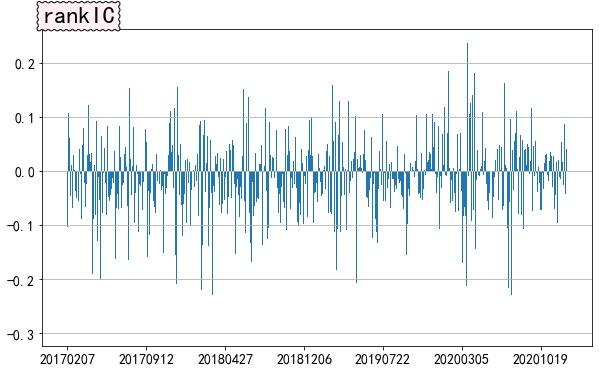

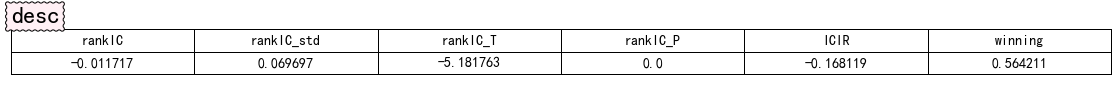

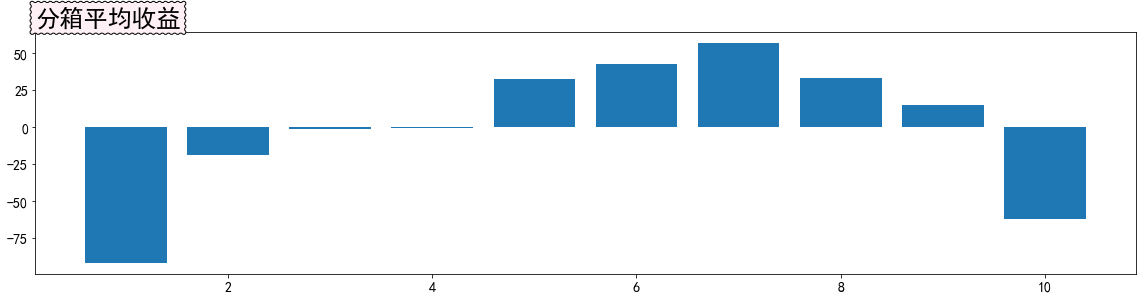

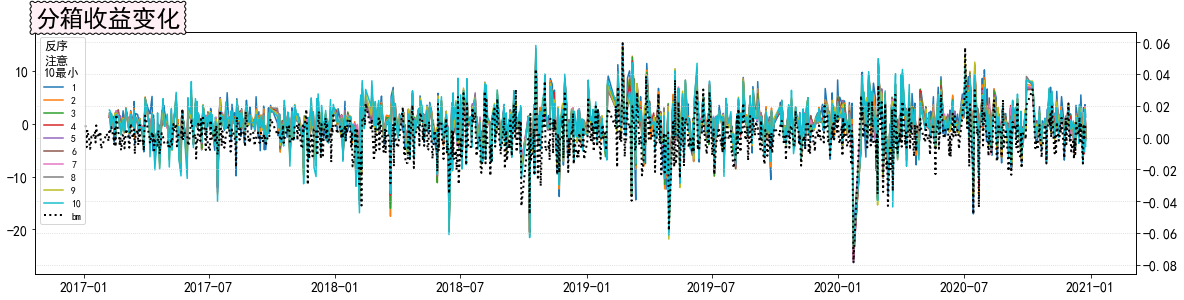

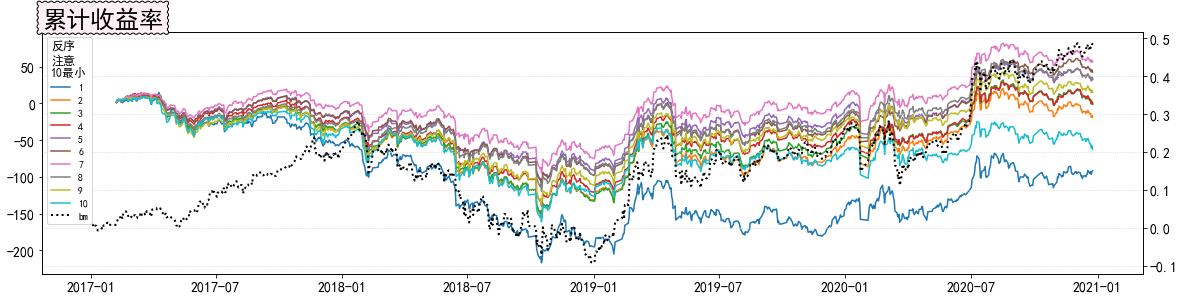

Wall time: 1min 22s


In [161]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(interday_fluctuation_reverse).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


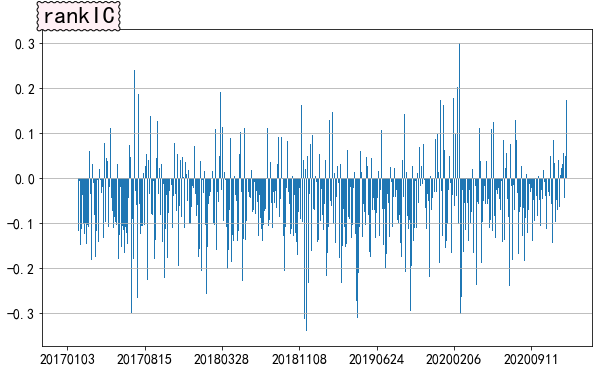

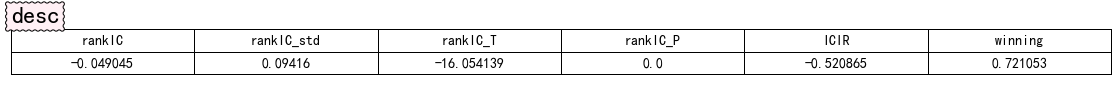

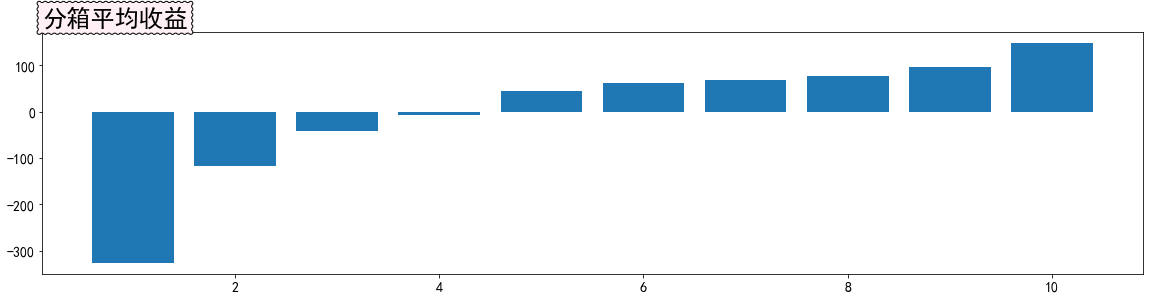

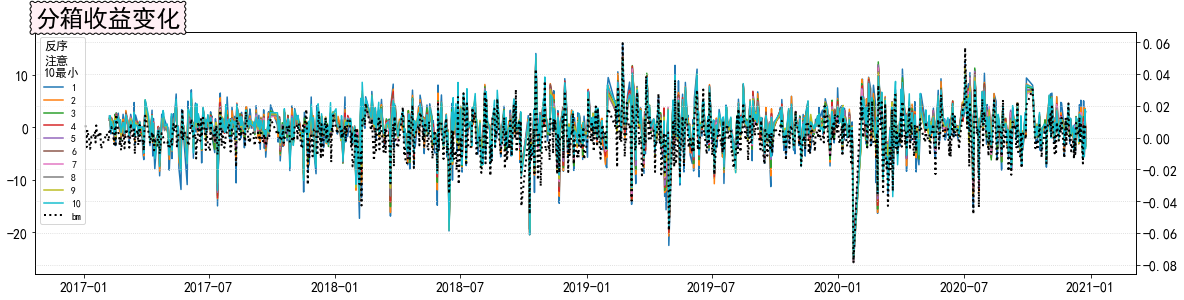

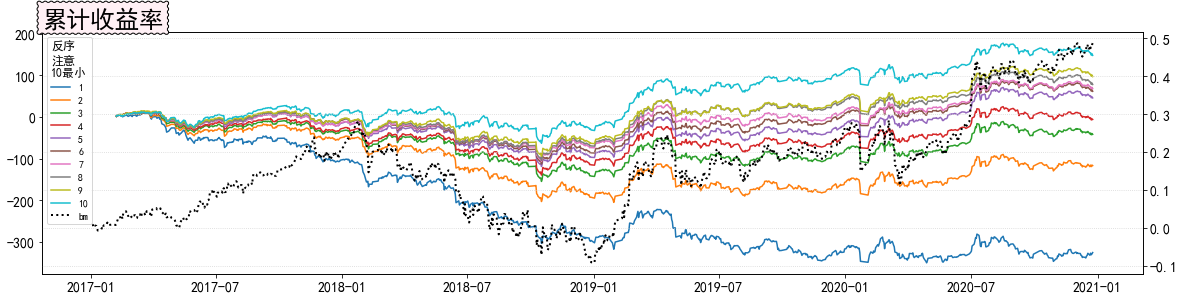

In [162]:
fa2 = pd.DataFrame(interday_turnover_reverse)
fa2.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa2,ret,need_descript=True)
test.plot()


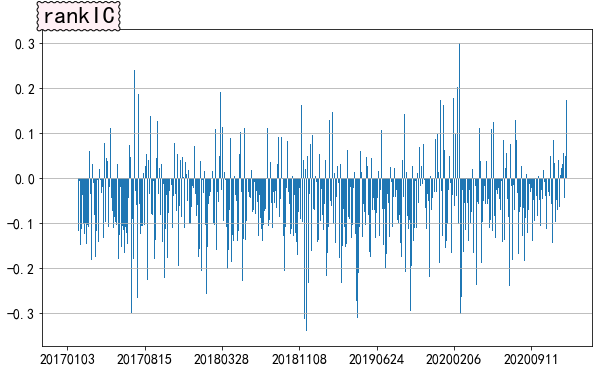

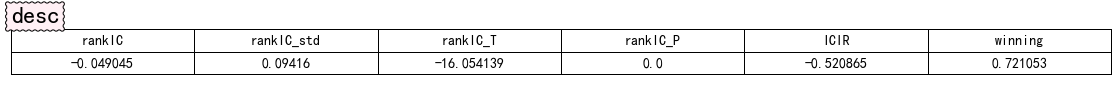

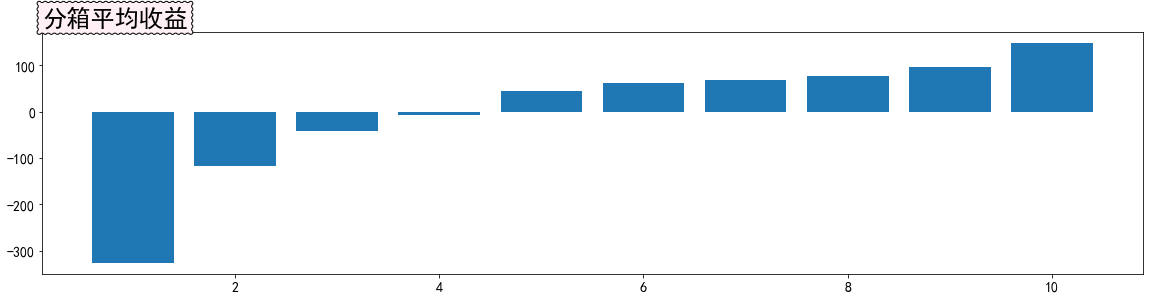

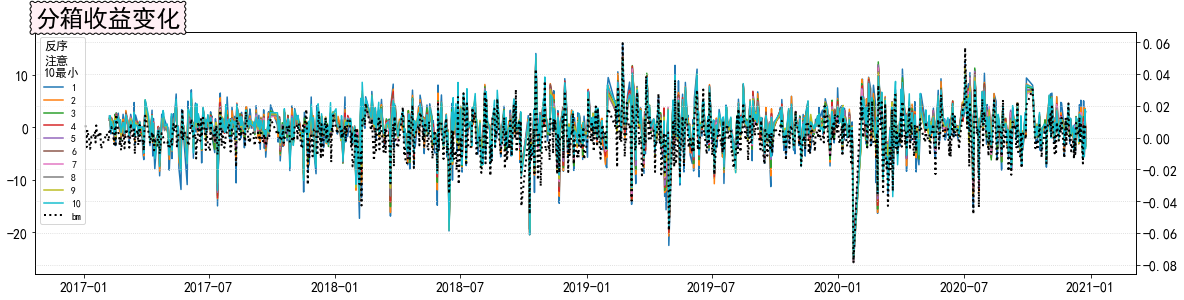

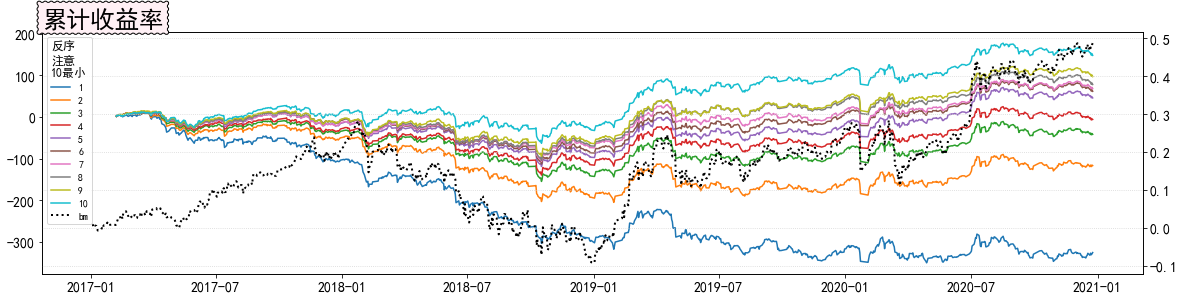

In [163]:
fa3 = pd.DataFrame(mixed)
fa3.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa2,ret,need_descript=True)
test.plot()

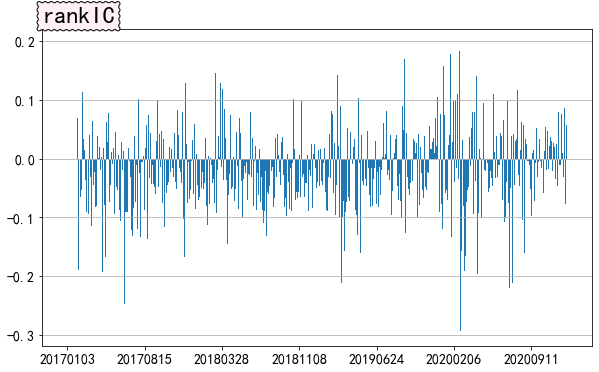

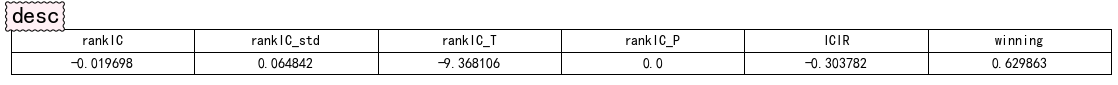

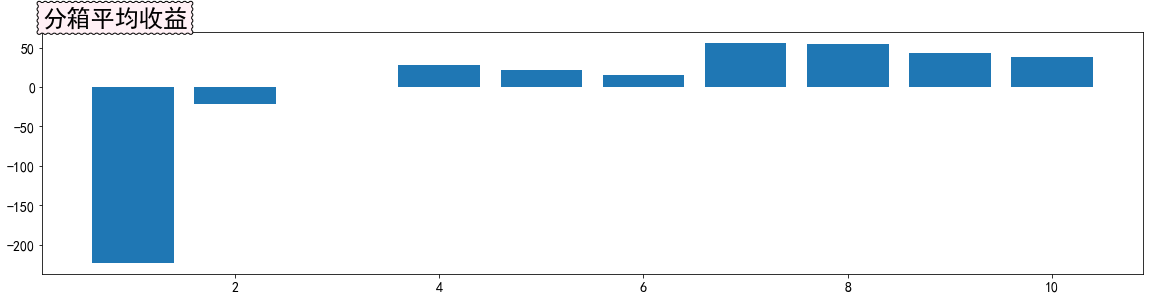

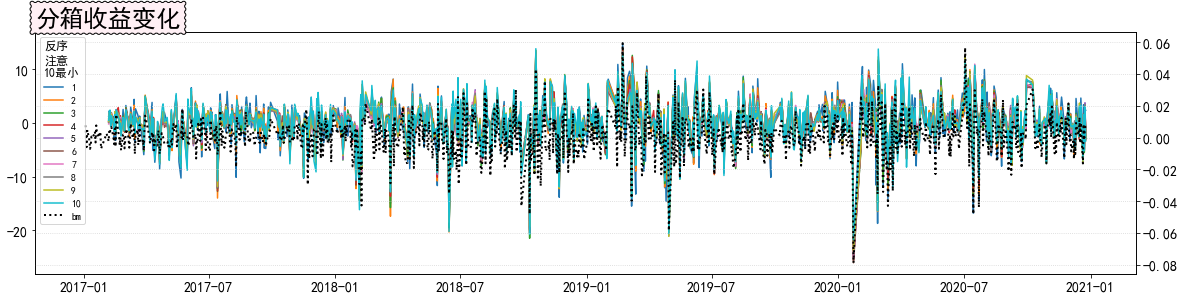

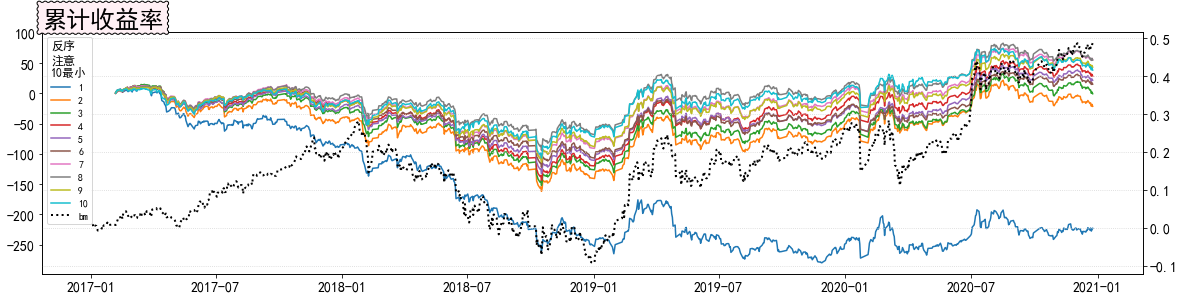

In [164]:
fa4 = pd.DataFrame(intraday_fluctuation_reverse)
fa4.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa4,ret,need_descript=True)
test.plot()

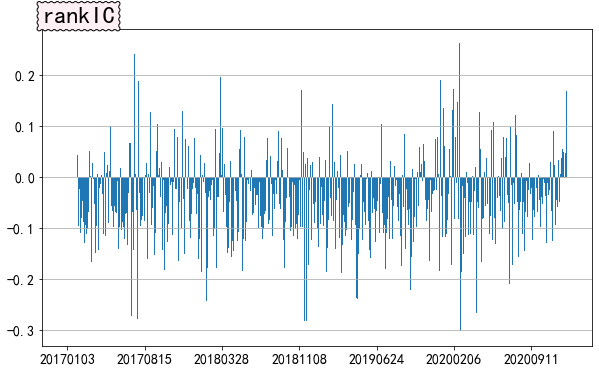

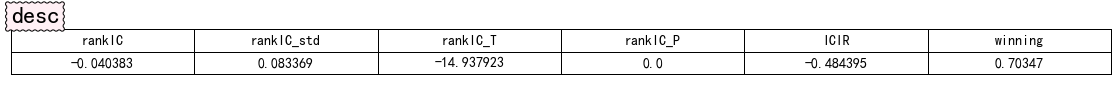

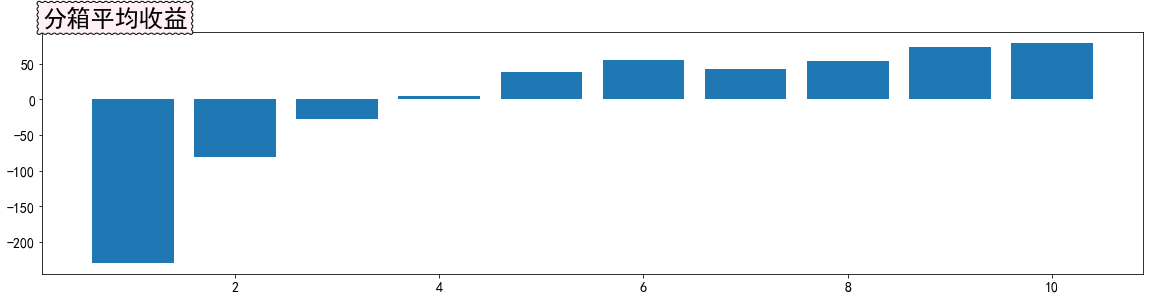

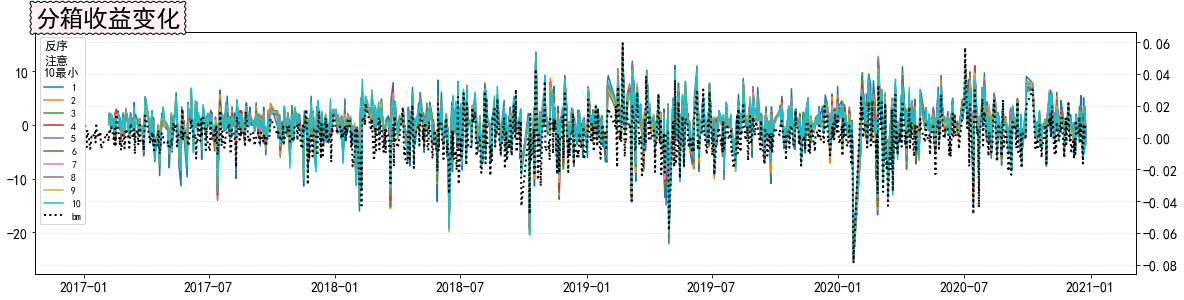

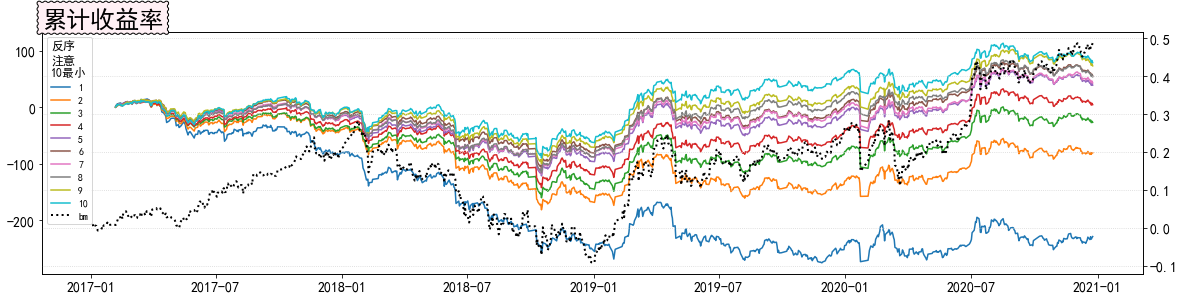

In [165]:
fa5 = pd.DataFrame(intraday_turnover_reverse)
fa5.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa5,ret,need_descript=True)
test.plot()

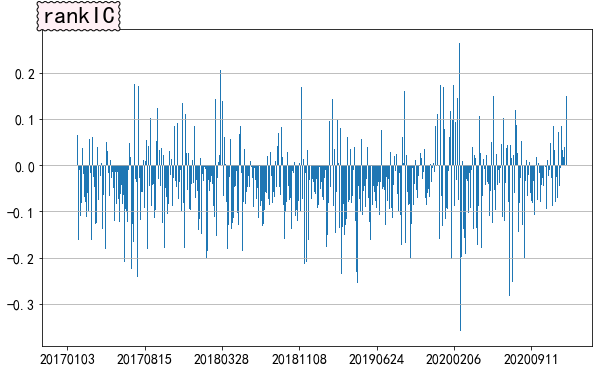

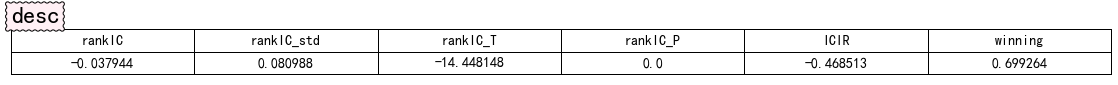

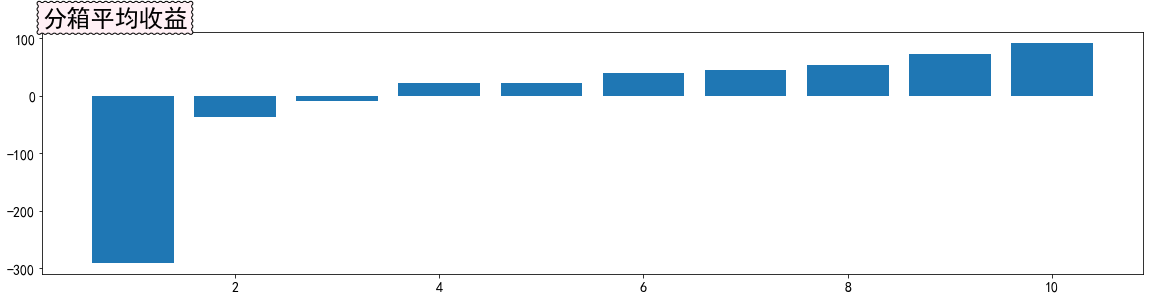

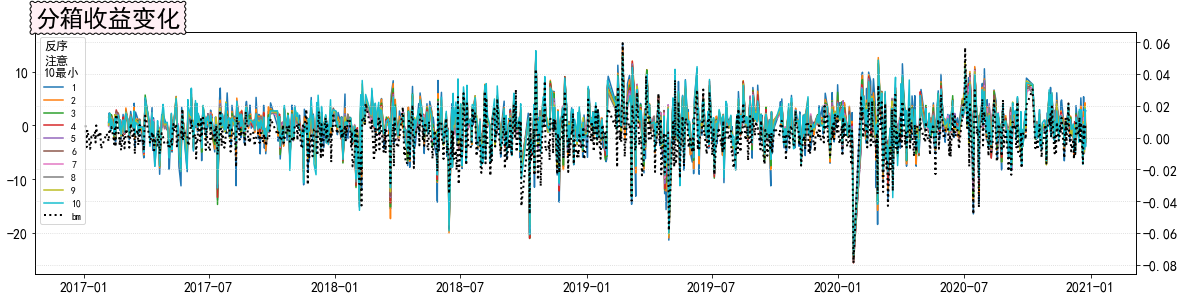

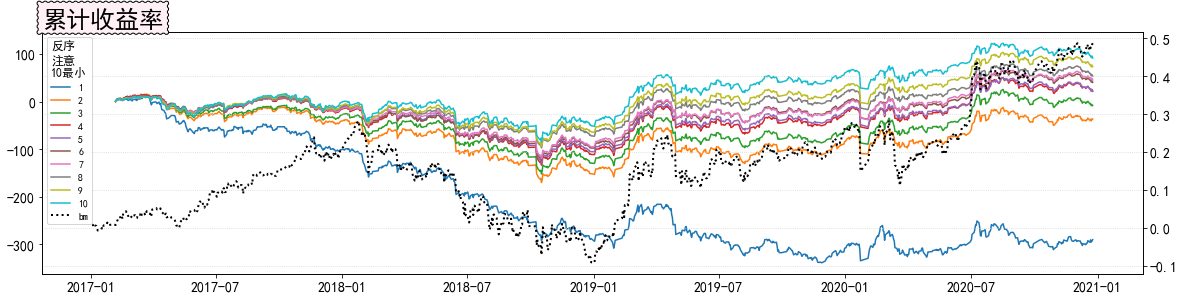

In [166]:
fa6 = pd.DataFrame(mixed2)
fa6.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa6,ret,need_descript=True)
test.plot()

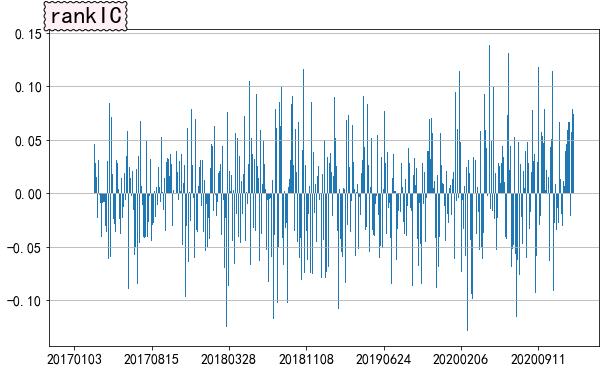

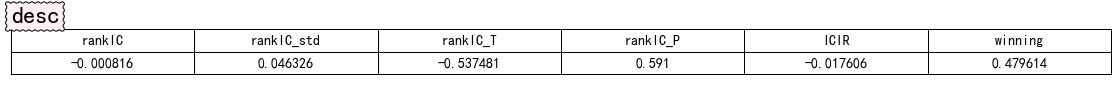

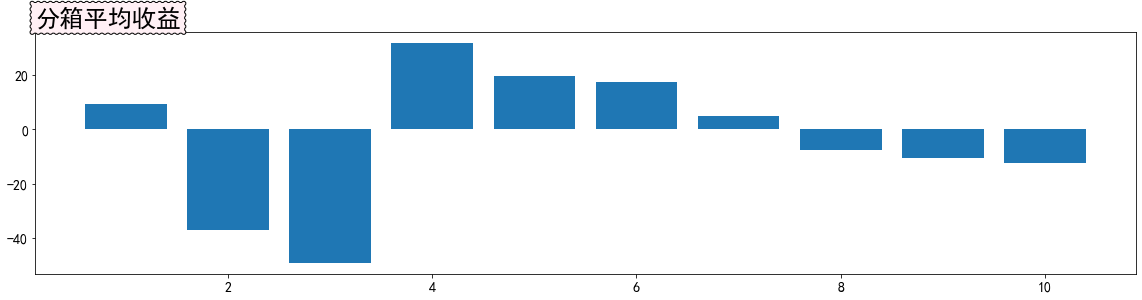

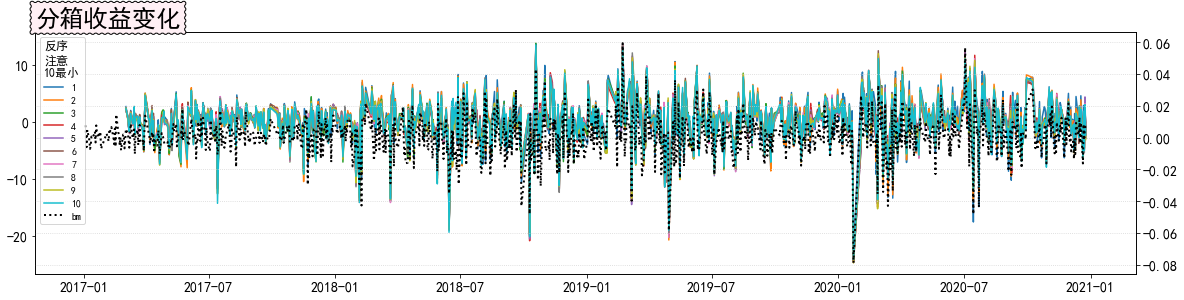

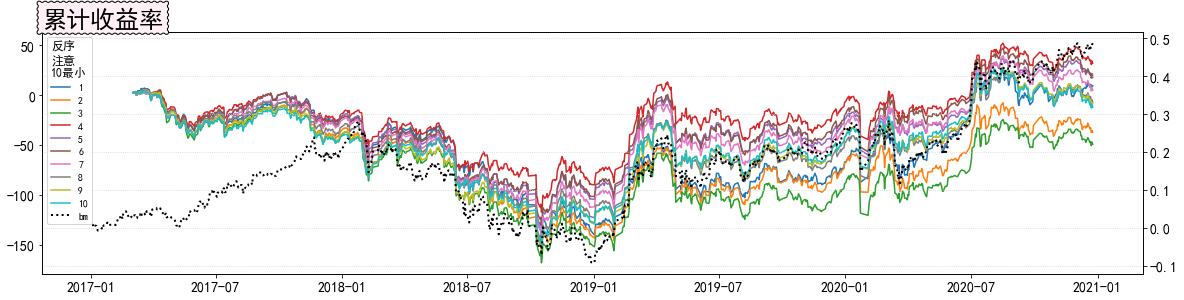

In [167]:
fa6 = pd.DataFrame(overnight_fluctuation_reverse)
fa6.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa6,ret,need_descript=True)
test.plot()

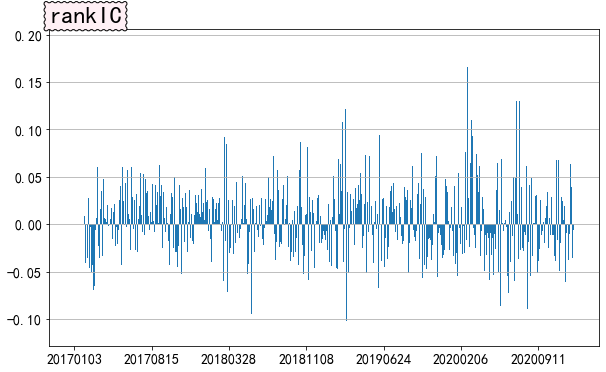

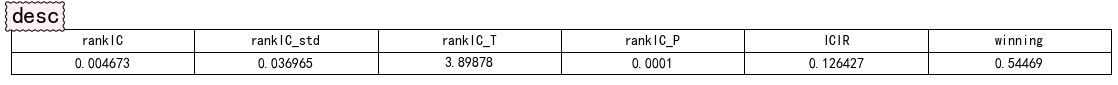

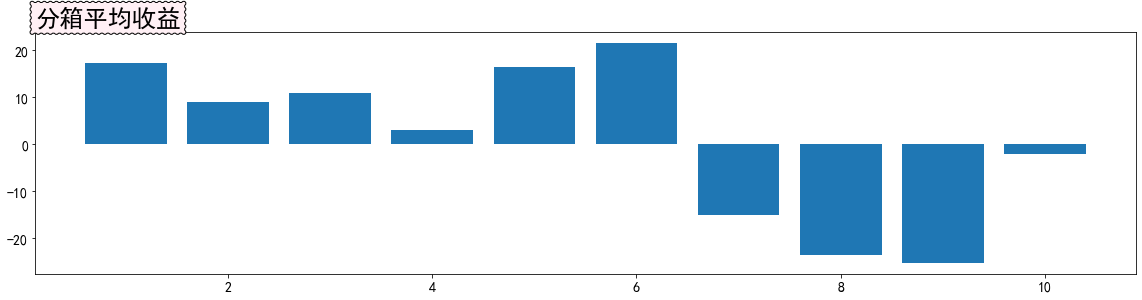

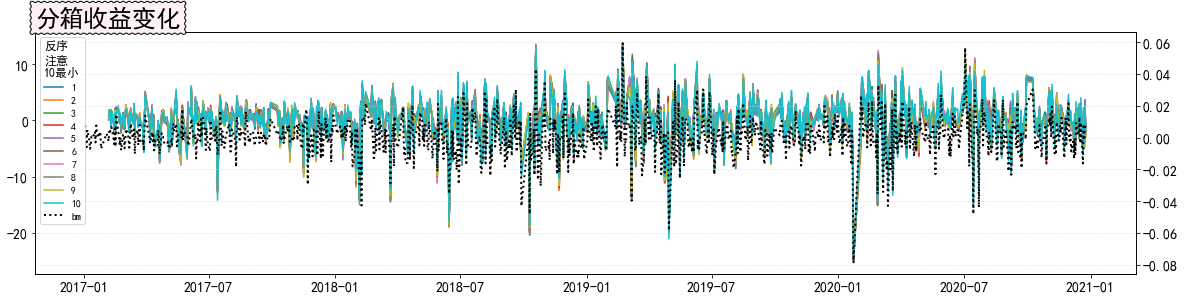

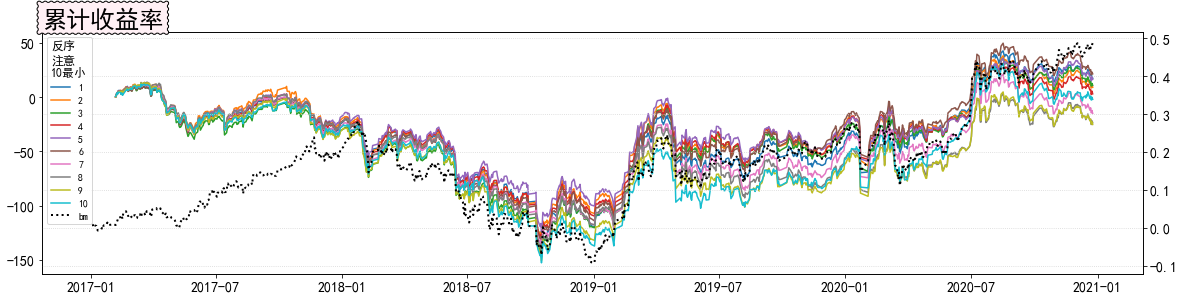

In [168]:
fa6 = pd.DataFrame(overnight_turnover_reverse)
fa6.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa6,ret,need_descript=True)
test.plot()

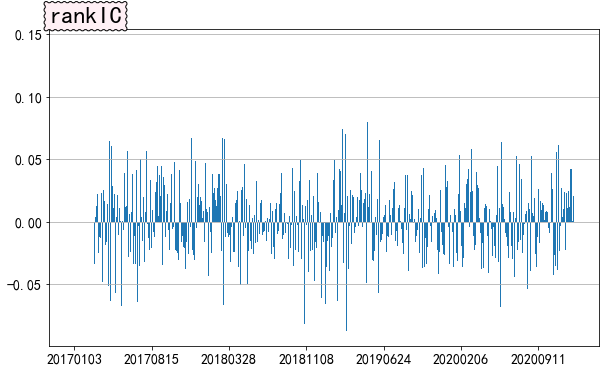

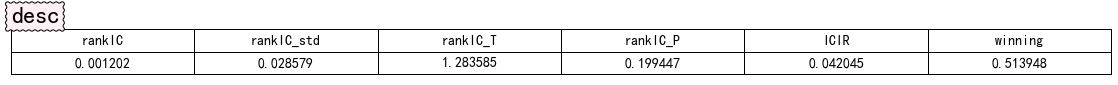

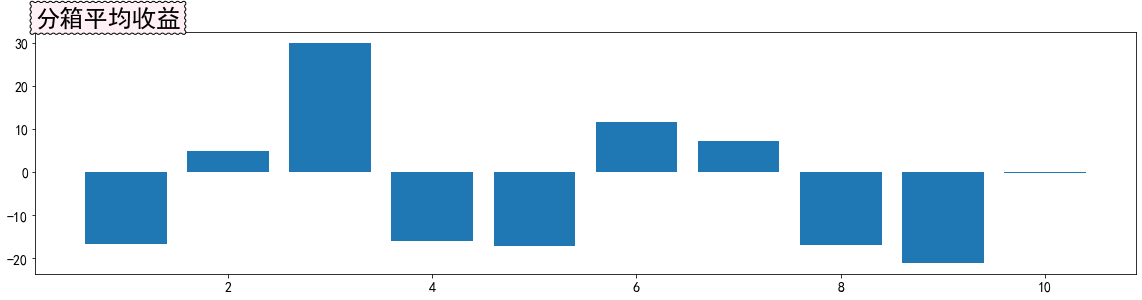

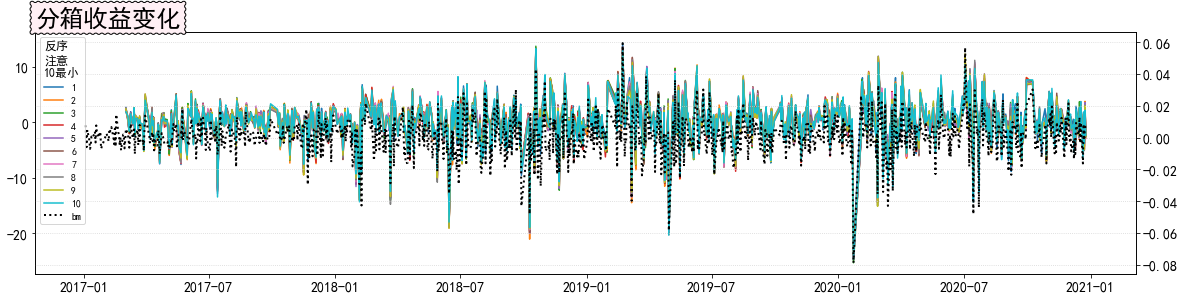

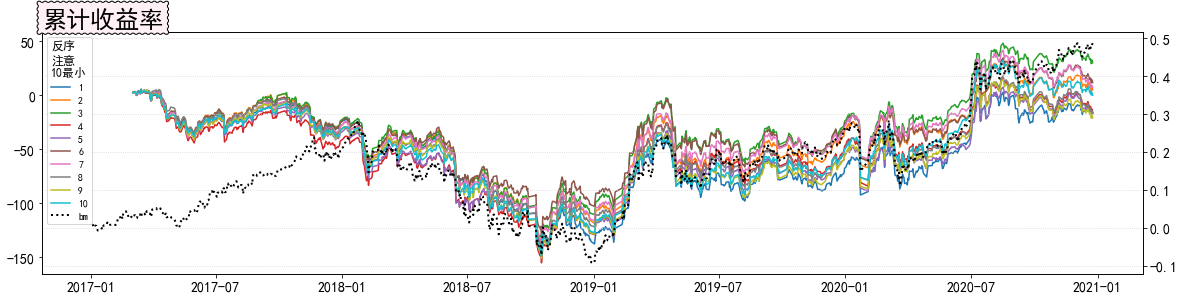

In [169]:
fa6 = pd.DataFrame(mixed3)
fa6.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa6,ret,need_descript=True)
test.plot()

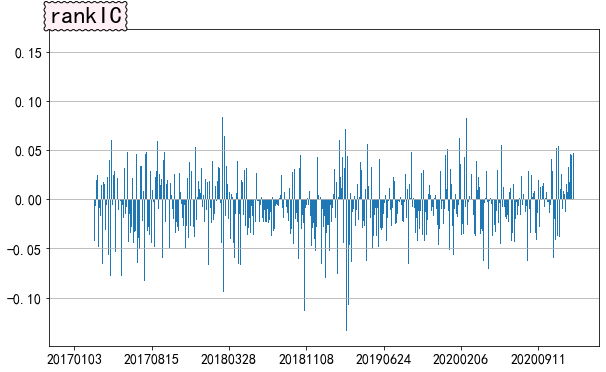

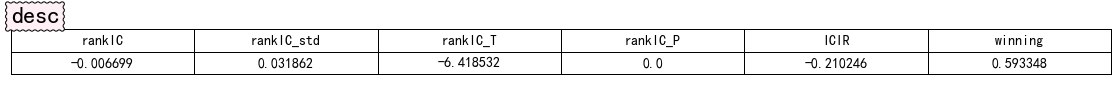

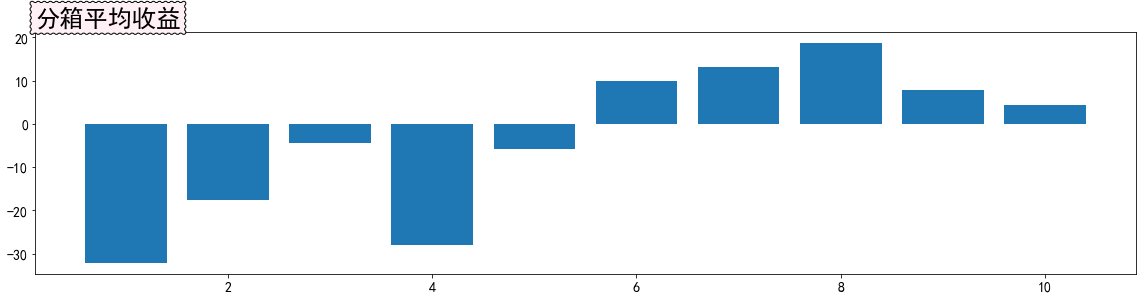

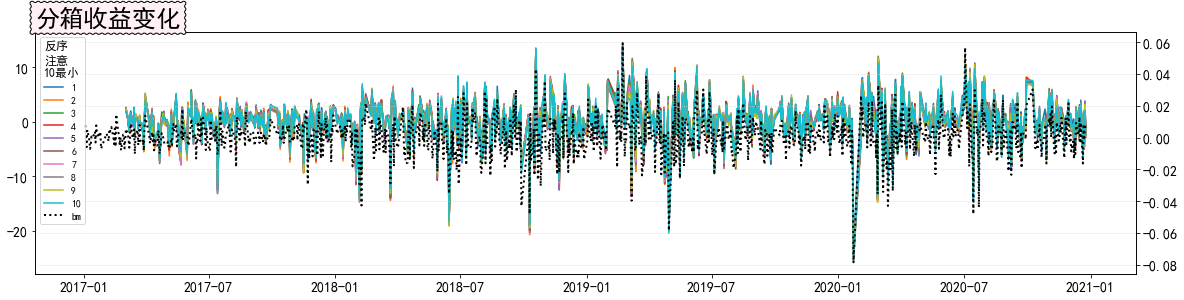

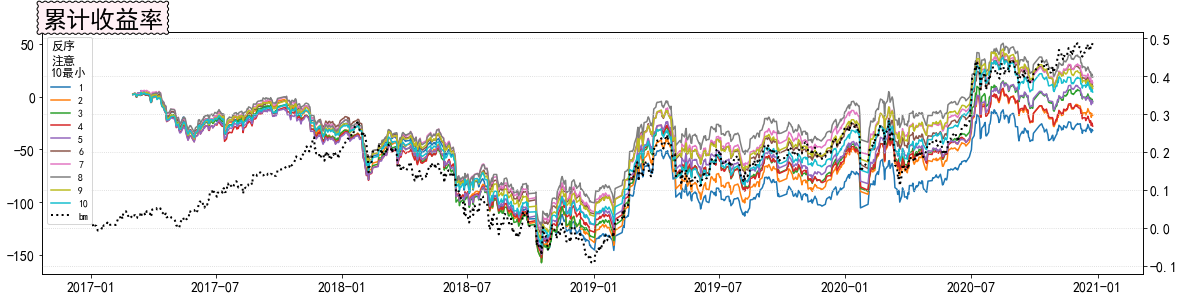

In [170]:
fa6 = pd.DataFrame(final_mixed)
fa6.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa6,ret,need_descript=True)
test.plot()